# Aprendizado por Reforço — Aula 2: k-Armed Bandits
**Prof. Domingos Napolitano — IBMEC**  
*Baseado em: Sutton & Barto (2018), "Reinforcement Learning: An Introduction", Cap. 2*

---

## Sumário

1. [O Dilema Fundamental](#1-o-dilema-fundamental)
2. [O Problema da Escolha](#2-o-problema-da-escolha)
3. [O Feedback Avaliativo e a Recompensa $R_t$](#3-o-feedback-avaliativo-e-a-recompensa-rt)
4. [O Objetivo: Maximização](#4-o-objetivo-maximização)
5. [O Valor da Ação: $q_*(a)$ e $Q_t(a)$](#5-o-valor-da-ação-qa-e-qta)
6. [Estimando o Valor: Média Amostral](#6-estimando-o-valor-média-amostral)
7. [Implementação Eficiente: Atualização Incremental](#7-implementação-eficiente-atualização-incremental)
8. [O Dilema: Exploração vs. Explotação](#8-o-dilema-exploração-vs-explotação)
9. [A Falha da Abordagem Greedy Pura](#9-a-falha-da-abordagem-greedy-pura)
10. [O Método $\varepsilon$-Greedy](#10-o-método-ε-greedy)
11. [Não-Estacionariedade e Passo Constante $\alpha$](#11-não-estacionariedade-e-passo-constante-α)
    - 11.1 Implementação: `tracking_bandit`
12. [Otimismo Diante da Incerteza](#12-otimismo-diante-da-incerteza)
    - 12.1 Experimento: Otimista vs. Realista — Figura 2.3
13. [Exploração Inteligente: UCB](#13-exploração-inteligente-ucb)
    - 13.1 Implementação: `ucb_bandit`
    - 13.2 O Ambiente com Médias Aleatórias
    - 13.3 Experimento: UCB vs. ε-greedy — Figura 2.4
14. [Implementação Python Completa](#14-implementação-python-completa)
15. [Experimento e Reprodução das Figuras](#15-experimento-e-reprodução-das-figuras)
16. [Verificação dos Q-values Estimados](#16-verificação-dos-q-values-estimados)
17. [Resumo das Notações](#17-resumo-das-notações)

## 1. O Dilema Fundamental

> *Slide 2 — "O Dilema do Bandido de k-braços: Exploração vs. Explotação"*

O problema do **Bandido de k-braços** é o ambiente mais simples do Aprendizado por Reforço, mas contém o dilema central de toda a área: **deve o agente usar o que já sabe (explotação) ou tentar descobrir algo melhor (exploração)?**

```
┌─────────────────────────────────────────────┐
│            O DILEMA FUNDAMENTAL             │
│                                             │
│   EXPLOTAÇÃO          EXPLORAÇÃO            │
│   ──────────          ─────────             │
│   Maximiza o ganho    Busca conhecimento    │
│   imediato; escolhe   para maiores ganhos   │
│   a melhor estimativa a longo prazo         │
│   atual                                     │
└─────────────────────────────────────────────┘
```

**Três estratégias principais** para equilibrar esse dilema:

| Estratégia | Lógica de Exploração | Ideal Para |
|---|---|---|
| $\varepsilon$-greedy | Aleatória com probabilidade $\varepsilon$ | Ambientes ruidosos e complexos |
| UCB | Determinística (baseada em incerteza) | Bandidos estacionários (estado da arte) |
| Otimista | Valores iniciais altos (força testes) | Problemas estacionários simples |

## 2. O Problema da Escolha

> *Slides 6 e 18 — "O Problema da Escolha" e "O Cenário: O Problema do Bandido de k-braços"*

**Cenário:** O agente se depara repetidamente com uma escolha entre $k$ opções (ações) diferentes. A cada passo de tempo $t$, ele seleciona uma ação e recebe uma recompensa estocástica.

**Definição formal** do conjunto de ações:

$$\mathcal{A} = \{1, 2, \ldots, k\}$$

Os quatro elementos do problema são:

1. **Agente** — tomador de decisão (o algoritmo)
2. **Ação** $A_t$ — escolha entre $k$ opções no instante $t$
3. **Recompensa** $R_t$ — feedback numérico após a ação
4. **Objetivo** — maximizar a soma total de recompensas

**Analogias do dia a dia:**
- Um médico escolhendo entre $k$ tratamentos experimentais para uma série de pacientes
- Um aplicativo de delivery escolhendo qual restaurante recomendar para maximizar a satisfação do usuário

### O Ambiente Python: BanditEnv (10 braços)

O código abaixo implementa um ambiente "testbed" clássico de 10 braços, conforme descrito em Sutton & Barto (2018), Figura 2.1. Cada braço tem uma recompensa média fixa (`means`), e as recompensas reais são amostradas de uma distribuição Normal ao redor dessa média.

```python
import numpy as np
import matplotlib.pyplot as plt

class BanditEnv:
    def __init__(self):
        """
        Ambiente testbed de 10 braços — ver Sutton & Barto, seção 2.3.
        Cada braço 'a' tem um valor real q*(a) fixo (a 'verdade oculta').
        As recompensas são amostradas de N(q*(a), 1), ou seja:
        - Média: q*(a)  →  o que queremos estimar com Q_t(a)
        - Desvio padrão: 1  →  o ruído que dificulta o aprendizado
        """
        self.size = 10  # número de braços (ações disponíveis)

        # Valores reais q*(a) de cada braço — desconhecidos pelo agente!
        # Foram definidos manualmente para reproduzir a Figura 2.1 do livro.
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,
                               -1.5, -0.25, -1, 0.75, 

    def step(self, action):
        """
        Executa uma ação e retorna a recompensa estocástica.
        R_t ~ N(q*(action), 1)
        O agente vê apenas R_t — NÃO tem acesso direto a q*(action).
        """
        return np.random.normal(loc=self.means[action])
```

> **Legenda Figura 2.1:** Distribuição de recompensas de cada braço visualizada como violin plot. A linha central de cada violino representa a média $q_*(a)$. O agente não vê essas distribuições — ele precisa estimá-las experimentando cada ação.

## 3. O Feedback Avaliativo e a Recompensa $R_t$

> *Slide 7 — "O Feedback Avaliativo"*

Após cada escolha, o agente recebe um valor numérico chamado **recompensa**:

$$R_t \in \mathbb{R}$$

**Três propriedades importantes:**

**A Recompensa $R_t$:** Após cada escolha, recebemos um valor numérico que mede a qualidade da decisão tomada.

**Natureza Estocástica:** A recompensa vem de uma distribuição de probabilidade. O mesmo braço pode dar recompensas diferentes em momentos distintos — como um prato que pode estar mais ou menos saboroso a cada pedido (ruído/variância).

**Diferença Chave do Aprendizado Supervisionado:** No aprendizado supervisionado, o sistema recebe a "resposta certa" (*"aqui está o rótulo correto"*). No bandido, o feedback apenas diz quão boa foi a ação escolhida (*"nota 7 de 10"*), mas **nunca** informa qual teria sido a melhor ação possível.

> Esta distinção é fundamental: estamos diante de **aprendizado por reforço**, não por supervisão.

## 4. O Objetivo: Maximização

> *Slide 8 — "O Objetivo: Maximização"*

**A Missão:** Maximizar a recompensa total esperada ao longo de um período de $T$ passos de tempo:

$$\text{Maximizar} \quad \mathbb{E}\left[\sum_{t=1}^{T} R_t\right]$$

**O Horizonte:** Não queremos apenas acertar na jogada atual. Queremos acumular o máximo de recompensa ao longo de, por exemplo, 1000 passos (como no experimento clássico do livro).

**Implicação estratégica:** Uma escolha *ruim agora* (para aprender sobre um braço desconhecido) pode valer a pena se isso permitir melhores escolhas no futuro — este é o núcleo do dilema exploração vs. explotação.

```
Recompensa Acumulada
      ▲
      │                               ╱─────
      │                          ╱───
      │                     ╱───
      │               ╱────
      │         ╱────
      │   ╱────
      └───────────────────────────────────► Tempo (t)
```

> **Legenda Figura:** A recompensa acumulada cresce mais rapidamente quando o agente aprende a identificar e escolher os melhores braços. Um bom equilíbrio entre exploração e explotação leva à curva mais íngreme.

## 5. O Valor da Ação: $q_*(a)$ e $Q_t(a)$

> *Slides 9, 10, 19 — "A Verdade Oculta", "A Estimativa", "Realidade vs. Estimativa"*

### 5.1 O Valor Real $q_*(a)$ — A Verdade Oculta

O **valor real** de uma ação $a$ é definido como a **recompensa esperada** ao escolher $a$:

$$q_*(a) \doteq \mathbb{E}[R_t \mid A_t = a]$$

**Intuição:** Se pedíssemos o mesmo prato infinitas vezes, qual seria a nota média exata? Esse é o $q_*(a)$.

**O Desafio:** Se soubéssemos $q_*(a)$ para todas as ações, o problema seria trivial (bastaria escolher sempre o maior). O problema é que **o agente não tem acesso a $q_*(a)$** — ele só observa as recompensas ruidosas $R_t$.

### 5.2 A Estimativa $Q_t(a)$ — Nossa Melhor Aposta

Como não sabemos $q_*(a)$, o agente mantém uma **estimativa** $Q_t(a)$: nossa melhor aposta atual sobre o valor de cada ação, baseada nas experiências passadas.

$$Q_t(a) \approx q_*(a)$$

**O aprendizado ocorre na tentativa de fazer a estimativa convergir para o valor real através da observação:**

$$q_*(a) \quad \underbrace{\longleftarrow}_{\text{aprendizado}} \quad Q_t(a)$$

No código Python, as estimativas são inicializadas como zero:
```python
# Inicialização: estimativa inicial de Q_t(a) = 0 para todos os braços
# Esta é uma escolha "pessimista" — veremos alternativas na seção de Otimismo
Q = np.zeros(env.size)   # Q[a] = estimativa do valor do braço 'a'
N = np.zeros(env.size)
```

## 6. Estimando o Valor: Média Amostral

> *Slides 10 e 25 — "A Estimativa: Descobrindo o Valor" e "Estimando Valor: Média Amostral"*

A abordagem mais natural para estimar $q_*(a)$ é calcular a **média das recompensas passadas** para aquela ação:

$$Q_t(a) \doteq \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbf{1}_{A_i = a}}{\sum_{i=1}^{t-1} \mathbf{1}_{A_i = a}}$$

onde $\mathbf{1}_{A_i = a}$ é 1 se a ação $a$ foi escolhida no passo $i$, e 0 caso contrário.

Em palavras:

$$Q_t(a) = \frac{\text{Soma das recompensas recebidas pela ação } a}{\text{Número de vezes que } a \text{ foi escolhida}}$$

**Lei dos Grandes Números:** Conforme $n \to \infty$, temos $Q_t(a) \to q_*(a)$. Ou seja, com amostras suficientes, a estimativa converge para a verdade.

> **Legenda Figura:** Dispersão de pontos (amostras de recompensa) convergindo em torno de uma linha central (o valor real $q_*(a)$). À medida que coletamos mais amostras, a nuvem de pontos se comprime e a estimativa fica cada vez mais precisa.

## 7. Implementação Eficiente: Atualização Incremental

> *Slides 11 e 26 — "Implementação Eficiente (Incremental)" e "Eficiência Computacional"*

**Problema:** Armazenar todo o histórico de recompensas para recalcular a média a cada passo gasta muita memória e é computacionalmente custoso $O(n)$.

**Solução:** Atualização **incremental** em $O(1)$ — atualizamos a estimativa passo a passo, sem guardar o histórico:

$$Q_{n+1} = Q_n + \frac{1}{n}\left[R_n - Q_n\right]$$

```
┌──────────┐      ┌──────┐      ┌────────────┐      ┌──────────────┐      ┌───────────┐
│Estimativa│ ───► │ Ação │ ───► │ Recompensa │ ───► │    Erro      │ ───► │   Nova    │
│  Atual   │      │      │      │   (R_n)    │      │ (R_n − Q_n) │      │ Estimativa│
│  (Q_n)  │      │      │      │            │      │              │      │ (Q_{n+1}) │
└──────────┘      └──────┘      └────────────┘      └──────────────┘      └───────────┘
      ▲                                                                           │
      └───────────────────────────────────────────────────────────────────────────┘
```

**Conceito Geral:**

$$\text{Nova Estimativa} = \text{Velha Estimativa} + \underbrace{\frac{1}{n}}_{\text{Passo}} \times \underbrace{[R_n - Q_n]}_{\text{Erro (Target - Old)}}$$

Esta fórmula é **universal** no Aprendizado por Reforço. Ela aparece em TD-learning, Q-learning, Actor-Critic, etc. O "erro" $[R_n - Q_n]$ mede o quanto nossa previsão estava errada, e damos um passo proporcional a esse erro para corrigir.

No código Python, a atualização incremental fica em uma única linha:

```python
# Atualização incremental de Q[A]:
# Nova estimativa = Velha + (1/N[A]) * (Recompensa_recebida - Velha)
# Isso equivale à média amostral SEM precisar guardar histórico!
Q[A] += (1 / N[A]) * (R - Q[A])
```

## 8. O Dilema: Exploração vs. Explotação

> *Slides 12, 20, 21, 22 — "O Dilema", "Explotação", "Exploração", "O Conflito de Escolha Simultânea"*

Este é o dilema central do Aprendizado por Reforço.

### Explotação (Exploitation) — "Aproveitar"

$$A_t = \underset{a}{\operatorname{argmax}} \, Q_t(a)$$

**Definição:** Usar o conhecimento atual para maximizar a recompensa imediata — escolher o braço com maior $Q_t$.

**Mentalidade:** *"Vou ao restaurante que eu já sei que é bom."*

**Vantagem:** Garante o melhor ganho imediato segundo o conhecimento atual.
**Desvantagem:** Não gera aprendizado — se nossa estimativa estiver errada, ficamos presos numa escolha subótima.

### Exploração (Exploration) — "Explorar"

**Definição:** Escolher uma ação aparentemente inferior para melhorar a estimativa do seu valor e reduzir a incerteza.

**Mentalidade:** *"Vou experimentar aquele lugar novo; pode ser ruim, mas pode ser incrível."*

**Vantagem:** Coleta informações e reduz incerteza, potencialmente levando a ganhos maiores no futuro.
**Desvantagem:** Sacrifica ganho imediato.

> *"O risco de curto prazo é o preço do conhecimento de longo prazo."*

### O Conflito

**Você não pode explorar e explotar na mesma jogada.**

- Explotação → Maximiza retorno em um passo
- Exploração → Investimento para retorno total a longo prazo

## 9. A Falha da Abordagem Greedy Pura

> *Slide 23 — "A Falha da Abordagem Puramente Gananciosa"*

A estratégia **greedy pura** sempre escolhe:

$$A_t = \underset{a}{\operatorname{argmax}} \, Q_t(a)$$

**A Armadilha:** Se a primeira experiência com a ação ótima for negativa (por azar do ruído), o agente nunca mais volta a ela. A estimativa inicial errada "contamina" permanentemente a decisão.

**Resultado:** Convergência prematura para uma ação subótima.

> **Legenda Figura 2.2 (parte):** O método greedy ($\varepsilon=0$) converge rápido inicialmente, mas se estabiliza bem abaixo do desempenho ótimo. No testbed de 10 braços, o método greedy encontrou a ação ótima em apenas ~33% das tarefas — ficou preso nas demais.

A função auxiliar abaixo lida com **empates aleatórios** — quando o `np.argmax()` padrão sempre escolhe o primeiro máximo, introduzindo um viés:

```python
def argmax_rand(arr):
    """
    Retorna o índice do valor máximo do array,
    quebrando empates de forma ALEATÓRIA.

    Por que isso importa?
    np.argmax() sempre retorna o PRIMEIRO índice em caso de empate.
    No início, Q = [0, 0, 0, ...] — todos empatados!
    Se não quebrarmos empates aleatoriamente, o agente sempre
    escolheria o braço 0 primeiro, introduzindo um viés injusto.
    """
    return np.random.choice(np.flatnonzero(arr == arr.max()))
```

## 10. O Método $\varepsilon$-Greedy

> *Slides 13 e 24 — "Resolvendo o Dilema: Métodos ε-Greedy" e "O Método ε-greedy"*

**Solução:** Inserir aleatoriedade **controlada** — na maioria das vezes explotar, mas com probabilidade $\varepsilon$ explorar aleatoriamente.

$$A_t = \begin{cases} \underset{a}{\operatorname{argmax}} \, Q_t(a) & \text{com probabilidade } 1 - \varepsilon \quad \text{(Explotação)} \\ \text{ação aleatória} & \text{com probabilidade } \varepsilon \quad \text{(Exploração)} \end{cases}$$

```
         Decisão
        /        \
   1 − ε           ε
      /               \
Ação Gananciosa    Ação Aleatória
  (Max Q_t)         (Exploração)
```

**Garantia importante:** O método $\varepsilon$-greedy garante **assintoticamente** que todas as ações sejam testadas — o agente nunca ficará preso para sempre numa ação subótima.

> **Legenda Figura 2.2:** Comparação das curvas de recompensa média por passo. O $\varepsilon$-greedy com $\varepsilon=0.1$ supera o greedy ($\varepsilon=0$) após suficientes passos de exploração. Com $\varepsilon=0.01$ a curva sobe mais devagar, mas pode ultrapassar $\varepsilon=0.1$ no longo prazo (pois explora menos e exploita mais).

## 11. Não-Estacionariedade e Passo Constante $\alpha$

> *Slides 14 e 29 — "Quando o Mundo Muda: Não-Estacionariedade" e "Problemas Não-Estacionários"*

### O Problema

E se o valor real $q_*(a)$ **mudar com o tempo**? (Ex: um novo chef no restaurante mudou a qualidade da comida.)

**Falha da Média Simples:** A fórmula $Q_{n+1} = Q_n + \frac{1}{n}[R_n - Q_n]$ usa passo $\frac{1}{n}$ que **diminui** com o tempo. No início aprende rápido, mas com muitas amostras torna-se insensível a mudanças recentes — lembra demais do passado distante.

### A Solução: Passo Constante $\alpha$

Em vez de $\frac{1}{n}$, usamos um **passo constante** $\alpha \in (0, 1]$:

$$Q_{n+1} = Q_n + \alpha \left[R_n - Q_n\right]$$

Esta fórmula implementa uma **Média Ponderada Exponencial**: recompensas recentes recebem mais peso, recompensas antigas são gradualmente "esquecidas".

Expandindo a recursão:

$$Q_{n+1} = (1-\alpha)^n Q_1 + \sum_{i=1}^{n} \alpha(1-\alpha)^{n-i} R_i$$

O peso de $R_i$ decai exponencialmente com $(1-\alpha)^{n-i}$ — quanto mais antiga a recompensa, menor seu peso.

> **Legenda Figura (Slide 29):** Quando $q_*(a)$ salta abruptamente (linha sólida azul), a Média Padrão (linha tracejada amarela) demora muito para reagir. A Média Exponencial (linha sólida cinza) se adapta muito mais rapidamente à nova realidade.

**Escolha do hiperparâmetro:**
- $\alpha$ grande (ex: 0.9) → adapta-se rapidamente, mas é instável/ruidoso
- $\alpha$ pequeno (ex: 0.01) → mais estável, mas lento para se adaptar
- $\alpha = \frac{1}{n}$ → média simples (boa para ambientes estacionários)

### 11.1 Implementação: `tracking_bandit`

> *Baseado em Sutton & Barto 2018, Cap. 2.5 — implementação de Marcin Bogdanski*

O `tracking_bandit` é idêntico ao `simple_bandit` com **duas diferenças estruturais**: usa passo constante `alpha` no lugar de `1/N[A]`, e aceita um valor de inicialização `Q_init` configurável. Isso o torna mais versátil — permite tanto a abordagem realista (Q_init=0) quanto a otimista (Q_init=5), ambas com rastreamento de ambientes não-estacionários.

```python
def tracking_bandit(env, nb, eps, alpha, Q_init):
    """
    Tracking Bandit — Sutton & Barto 2018, Seção 2.5, equação (2.5).

    Diferenças em relação ao simple_bandit:
    ----------------------------------------
    1) Passo constante alpha (não 1/N): dá mais peso a recompensas recentes.
       Ideal para ambientes onde q*(a) pode mudar com o tempo.
    2) Q_init configurável: permite testar inicialização realista (Q_init=0)
       ou otimista (Q_init=5) com o mesmo código.

    Parâmetros:
    -----------
    env    : BanditEnv  — ambiente do bandido
    nb     : int        — número de passos
    eps    : float      — probabilidade de exploração ε ∈ [0, 1]
    alpha  : float      — passo constante α ∈ (0, 1] para atualização
    Q_init : float      — valor inicial de todas as estimativas Q

    Retorna:
    --------
    Q      : ndarray (env.size,) — estimativas finais
    hist_A : ndarray (nb,)       — histórico de ações
    hist_R : ndarray (nb,)       — histórico de recompensas
    """
    # --- Histórico para análise posterior ---
    hist_A = []
    hist_R = []

    # --- Inicialização das estimativas com Q_init ---
    # Q_init=0  → "realista": começa sem viés, aprende do zero
    # Q_init=5  → "otimista": força exploração inicial (ver Seção 12)
    Q = np.zeros(env.size) + Q_init

    for _ in range(nb):
        # --- Seleção de Ação: ε-greedy (idêntico ao simple_bandit) ---
        if np.random.rand() > eps:
            A = argmax_rand(Q)              # explotação: escolhe o melhor estimado
        else:
            A = np.random.randint(env.size) # exploração: escolhe aleatoriamente

        # --- Interação com o Ambiente ---
        R = env.step(A)   # recompensa estocástica: R ~ N(q*(A), 1)

        # --- Atualização com Passo Constante α (a diferença chave!) ---
        # Simple Bandit:   Q[A] += (1/N[A]) * (R - Q[A])  → passo DIMINUI com n
        # Tracking Bandit: Q[A] += alpha    * (R - Q[A])  → passo CONSTANTE
        #
        # O passo constante implementa uma média ponderada exponencial:
        # Q_{n+1} = (1-α)^n * Q_1 + Σ α*(1-α)^(n-i) * R_i
        # Recompensas antigas têm peso (1-α)^k → se α=0.1, após 10 passos
        # o peso cai para (0.9)^10 ≈ 0.35; após 50 passos cai para 0.005.
        Q[A] += alpha * (R - Q[A])

        # --- Registro do histórico ---
        hist_A.append(A)
        hist_R.append(R)

    return Q, np.array(hist_A), np.array(hist_R)
```

## 12. Otimismo Diante da Incerteza

> *Slide 27 — "Otimismo Diante da Incerteza: Valores Iniciais Otimistas"*

**Estratégia alternativa de exploração:** Inicializar $Q_1(a)$ com valores **muito altos** — maiores que qualquer recompensa realista, ex: $Q_1 = +5$.

**Condição:** $Q_1 > q_*(a)$ para todo $a$.

### Como funciona?

O agente escolhe um braço com $Q_1 = 5$, recebe uma recompensa real (ex: $R \approx 1.5$), e "se decepciona" — sua estimativa cai. Então troca para outro braço, também com $Q_1 = 5$, e o mesmo ocorre. Isso força o agente a **visitar todos os braços** sistematicamente — sem usar aleatoriedade.

**Vantagens:**
- Exploração sistemática sem precisar de parâmetro $\varepsilon$
- Simples de implementar (apenas alterar a inicialização)

**Limitação:**
- Só funciona em ambientes **estacionários** (o otimismo inicial se esgota)
- Requer conhecimento prévio da escala das recompensas para escolher $Q_1$

> **Legenda Figura:** O método otimista ($Q_1 = 5$, linha sólida amarela) tem alta variância inicial (muita exploração forçada nos primeiros ~200 passos), mas depois converge para desempenho superior ao greedy simples ($Q_1 = 0$, linha tracejada cinza).

```python
# Exemplo: inicialização otimista
Q = np.ones(env.size) * 5.0   # Q_1(a) = +5 para todos os braços
N = np.zeros(env.size)
# A partir daqui, o loop de update é IDÊNTICO ao greedy normal
# A exploração emerge naturalmente da "decepção" com as recompensas reais
```

### 12.1 Experimento: Otimista vs. Realista — Figura 2.3

> *Baseado em Sutton & Barto 2018, Cap. 2.6 — Figura 2.3*

Este experimento usa o `tracking_bandit` (passo constante `alpha=0.1`) para comparar diretamente duas configurações clássicas:

| Configuração | `Q_init` | `eps` | Estratégia |
|---|---|---|---|
| **Otimista + Greedy** | `5` | `0` | Explora por "decepção", depois exploita sempre |
| **Realista + ε-greedy** | `0` | `0.1` | Explora aleatoriamente 10% do tempo, sempre |

#### Geração dos dados (2000 runs)

```python
import numpy as np
import matplotlib.pyplot as plt

env = BanditEnv()

# Listas para armazenar o histórico de ações de cada run
runs_opt_gr_A   = []   # Otimista + Greedy:     Q_init=5, eps=0,   alpha=0.1
runs_real_eps01 = []   # Realista + ε-greedy:   Q_init=0, eps=0.1, alpha=0.1

print('v' + ' ' * 18 + 'v')   # barra de progresso simples

for i in range(2000):   # 2000 runs independentes para média estatística robusta

    # --- Configuração 1: Otimista + Greedy ---
    # Q_init=5 força exploração inicial sem precisar de eps.
    # alpha=0.1 mantém sensibilidade a mudanças (tracking).
    # eps=0 significa: depois da fase otimista, SEMPRE exploita.
    _, hist_A, _ = tracking_bandit(env, nb=1000, eps=0, alpha=0.1, Q_init=5)
    runs_opt_gr_A.append(hist_A)

    # --- Configuração 2: Realista + ε-greedy ---
    # Q_init=0: sem viés inicial — o agente começa "agnóstico".
    # alpha=0.1: passo constante para rastrear possíveis mudanças.
    # eps=0.1: explora 10% aleatoriamente durante TODO o treinamento.
    _, hist_A, _ = tracking_bandit(env, nb=1000, eps=0.1, alpha=0.1, Q_init=0)
    runs_real_eps01.append(hist_A)

    if i % 100 == 0:
        print('.', end='')

# Converte para arrays numpy para operações vetorizadas
runs_opt_gr_A   = np.array(runs_opt_gr_A)    # shape: (2000, 1000)
runs_real_eps01 = np.array(runs_real_eps01)  # shape: (2000, 1000)
```

#### Cálculo da métrica: % de Ação Ótima

```python
# Identifica o braço ótimo — aquele com maior q*(a)
max_A = np.argmax(env.means)

# Para cada passo t, calcula a fração de runs que escolheu o braço ótimo
# shape de cada resultado: (1000,) — um valor por passo de tempo
opt_opt_gr_A    = np.average(runs_opt_gr_A   == max_A, axis=0)
opt_real_ep01_A = np.average(runs_real_eps01 == max_A, axis=0)
```

#### Reproduzindo a Figura 2.3

```python
fig = plt.figure()
ax  = fig.add_subplot(111)

# Otimista + Greedy: começa com alta exploração (instabilidade nos primeiros ~200 passos),
# depois converge para valores muito altos de ação ótima
ax.plot(opt_opt_gr_A,    linewidth=1., color='lightblue',
        label='Otimista, greedy, Q₁=5, ε=0')

# Realista + ε-greedy: sobe de forma mais gradual e estável,
# mas tem teto limitado porque sempre explora 10%
ax.plot(opt_real_ep01_A, linewidth=1., color='gray',
        label='Realista, ε-greedy, Q₁=0, ε=0.1')

ax.set_xlabel('Passos')
ax.set_ylabel('% Ação Ótima')
ax.set_title('Figura 2.3 — Otimista vs. Realista (Tracking Bandit, α=0.1)')
ax.legend()
plt.tight_layout()
plt.savefig('assets/fig_0203.png')
plt.show()
```

> **Legenda Figura 2.3:** A abordagem otimista ($Q_1=5$, azul claro) começa com muita oscilação — nos primeiros ~200 passos o agente troca de braço frequentemente, "decepcionado" com cada recompensa real abaixo de 5. Após essa fase de exploração forçada, o agente identifica o braço ótimo e converge para um percentual de ação ótima muito alto. A abordagem realista ($Q_1=0$, cinza) sobe de forma mais suave, mas nunca ultrapassa ~90% porque sempre reserva 10% do tempo para exploração aleatória. **Conclusão:** para ambientes estacionários, a inicialização otimista é uma alternativa eficaz ao ε-greedy.

## 13. Exploração Inteligente: UCB

> *Slide 28 — "Exploração Inteligente: UCB (Upper Confidence Bound)"*

**Problema do $\varepsilon$-greedy:** A exploração é **cega** — ao explorar, escolhe qualquer ação aleatoriamente, inclusive braços já muito explorados que sabidamente são ruins.

**Ideia do UCB:** Explorar com base no **potencial** (incerteza) de cada ação. Ações pouco visitadas têm maior incerteza sobre seu valor real, logo maior potencial de serem melhores do que pensamos.

$$A_t = \underset{a}{\operatorname{argmax}} \left[ Q_t(a) + c\sqrt{\frac{\ln t}{N_t(a)}} \right]$$

**Decomposição:**

$$\underbrace{Q_t(a)}_{\text{Explotação (Estimativa)}} + \underbrace{c\sqrt{\frac{\ln t}{N_t(a)}}}_{\text{Exploração (Incerteza)}}$$

onde:
- $Q_t(a)$ é a estimativa atual do valor (explotação)
- $N_t(a)$ é o número de vezes que a ação $a$ foi escolhida até $t$
- $c > 0$ controla o grau de exploração
- $\ln t$ cresce lentamente, garantindo que ações não visitadas sejam eventualmente testadas

**Mecânica:** Se uma ação não é escolhida ($N_t(a)$ pequeno), a incerteza $\sqrt{\frac{\ln t}{N_t(a)}}$ cresce, aumentando a pontuação total e **forçando** sua seleção eventualmente.

O UCB tem garantias teóricas mais fortes que o $\varepsilon$-greedy para ambientes **estacionários**.

### 13.1 Implementação: `ucb_bandit`

> *Baseado em Sutton & Barto 2018, Cap. 2.7, equação (2.10) — usado no AlphaZero*

O `ucb_bandit` tem uma estrutura em **dois loops** distintos, o que o diferencia do `simple_bandit`:

1. **Loop de inicialização:** visita cada braço exatamente uma vez antes de começar. Isso é necessário porque a fórmula UCB exige $N_t(a) > 0$ para evitar divisão por zero ($\frac{\ln t}{0} \to \infty$).
2. **Loop UCB principal:** a partir do passo $k+1$, aplica a fórmula de seleção com bônus de incerteza.

```python
def ucb_bandit(env, nb, c):
    """
    UCB Bandit (Upper Confidence Bound) — Sutton & Barto 2018, Seção 2.7.
    Equação (2.10): A_t = argmax_a [ Q_t(a) + c * sqrt(ln(t) / N_t(a)) ]

    Usado no AlphaZero (DeepMind, 2017) para seleção de jogadas na MCTS.

    Diferença fundamental em relação ao ε-greedy:
    - ε-greedy: explora ALEATORIAMENTE (cego — pode revisitar braços ruins)
    - UCB: explora com base na INCERTEZA (inteligente — prioriza braços pouco testados)

    Parâmetros:
    -----------
    env : BanditEnv — ambiente do bandido
    nb  : int       — número total de passos (incluindo a fase de inicialização)
    c   : float     — parâmetro de confiança (controla grau de exploração)
                      c grande → mais exploração; c pequeno → mais explotação
                      valor típico: c=2 (usado no experimento do livro)

    Retorna:
    --------
    Q      : ndarray (env.size,) — estimativas finais de Q_t(a)
    hist_A : ndarray (nb,)       — histórico de ações
    hist_R : ndarray (nb,)       — histórico de recompensas
    """
    # --- Inicialização ---
    Q      = np.zeros(env.size)   # estimativas Q_t(a) para cada braço
    N      = np.zeros(env.size)   # N_t(a): contagem de visitas por braço
    hist_A = []
    hist_R = []

    # ===================================================================
    # FASE 1: Inicialização — visita cada braço EXATAMENTE uma vez
    # ===================================================================
    # Por quê? A fórmula UCB usa sqrt(ln(t) / N_t(a)).
    # Se N_t(a) = 0 para algum braço, ocorre divisão por zero!
    # Visitando cada braço uma vez, garantimos N_t(a) >= 1 antes de aplicar UCB.
    # Esta fase cobre os primeiros 'env.size' (=10) passos do total 'nb'.
    for A in range(env.size):
        R = env.step(A)                    # pula cada braço uma vez (determinístico)
        N[A] += 1                          # agora N[A] = 1 para todos os braços
        Q[A] += (1 / N[A]) * (R - Q[A])   # atualização incremental padrão
        hist_A.append(A)
        hist_R.append(R)

    # ===================================================================
    # FASE 2: Loop UCB principal — passos env.size até nb-1
    # ===================================================================
    for t in range(env.size, nb):
        # --- Seleção de Ação: fórmula UCB ---
        # ucb_score[a] = Q[a] + c * sqrt(ln(t) / N[a])
        #                ↑ explotação     ↑ exploração (bônus de incerteza)
        #
        # Comportamento do bônus c * sqrt(ln(t) / N[a]):
        #   - Se N[a] é pequeno (braço pouco visitado): bônus GRANDE → força seleção
        #   - Se N[a] é grande (braço muito visitado):  bônus PEQUENO → confia na estimativa
        #   - ln(t) cresce com o tempo → todos os braços são visitados eventualmente
        #
        # argmax_rand quebra empates aleatoriamente (importante quando bônus iguala)
        A = argmax_rand(Q + c * np.sqrt(np.log(t) / N))

        # --- Interação com o Ambiente ---
        R = env.step(A)

        # --- Atualização Incremental (mesma fórmula do simple_bandit) ---
        N[A] += 1
        Q[A] += (1 / N[A]) * (R - Q[A])

        hist_A.append(A)
        hist_R.append(R)

    return Q, np.array(hist_A), np.array(hist_R)
```

### 13.2 O Ambiente com Médias Aleatórias

O experimento UCB do livro usa uma variação de `BanditEnv` onde os valores reais $q_*(a)$ são **sorteados aleatoriamente** a cada run — em vez de médias fixas. Isso cria cenários mais variados e testes mais robustos:

```python
class BanditEnv:
    def __init__(self):
        """
        Ambiente testbed de 10 braços com médias ALEATÓRIAS — Sutton & Barto, Seção 2.3.

        Diferença em relação ao BanditEnv do Simple Bandit:
        - Simple Bandit:  médias FIXAS  [0.25, -0.75, 1.5, ...]  → mesmo ambiente em todos os runs
        - UCB Bandit:     médias ALEATÓRIAS N(0,1) → ambiente diferente em cada run

        Por que usar médias aleatórias?
        Ao variar os q*(a) a cada run, o experimento testa se o algoritmo funciona
        de forma geral — não apenas para uma configuração específica de médias.
        O resultado médio sobre 2000 runs é mais representativo do desempenho real.
        """
        self.size  = 10   # número de braços

        # q*(a) ~ N(0, 1) para cada braço: valores reais DESCONHECIDOS pelo agente
        # A cada instância de BanditEnv, um novo conjunto de médias é gerado
        self.means = np.random.normal(loc=0.0, scale=1.0, size=self.size)

    def step(self, action):
        """
        Recompensa estocástica: R ~ N(q*(action), 1)
        Ruído com desvio padrão 1 em torno da média verdadeira do braço.
        """
        return np.random.normal(loc=self.means[action])
```

### 13.3 Experimento: UCB vs. ε-greedy — Figura 2.4

> *Baseado em Sutton & Barto 2018, Cap. 2.7 — Figura 2.4*

Este experimento compara diretamente o UCB (`c=2`) com o ε-greedy (`eps=0.1`) usando 2000 runs com ambientes de médias aleatórias. **Nota importante:** neste experimento, uma nova instância de `BanditEnv` é criada a cada run — garantindo que ambos os algoritmos enfrentem o mesmo ambiente em cada iteração para comparação justa.

```python
import numpy as np
import matplotlib.pyplot as plt

# Listas para recompensas de cada run
runs_ep01_R = []   # ε-greedy com ε=0.1
runs_ucb1_R = []   # UCB com c=2

print('v' + ' ' * 18 + 'v')

for i in range(2000):
    # IMPORTANTE: cria um NOVO BanditEnv a cada run
    # Isso garante que ambos os algoritmos enfrentem o MESMO ambiente por run
    # (os q*(a) são sorteados uma vez e usados nas duas chamadas)
    env = BanditEnv()

    # --- ε-greedy para comparação base ---
    _, _, hist_R = simple_bandit(env, nb=1000, eps=0.1)
    runs_ep01_R.append(hist_R)

    # --- UCB com parâmetro de confiança c=2 ---
    # c=2 é o valor usado no livro; valores maiores exploram mais,
    # valores menores exploitam mais (trade-off)
    _, _, hist_R = ucb_bandit(env, nb=1000, c=2.0)
    runs_ucb1_R.append(hist_R)

    if i % 100 == 0:
        print('.', end='')

# Converte para arrays para operações vetorizadas
runs_ep01_R = np.array(runs_ep01_R)   # shape: (2000, 1000)
runs_ucb1_R = np.array(runs_ucb1_R)  # shape: (2000, 1000)
```

#### Cálculo e plot da Figura 2.4

```python
# Recompensa média por passo, calculada sobre os 2000 runs
avg_ep01_R = np.average(runs_ep01_R, axis=0)   # shape: (1000,)
avg_ucb1_R = np.average(runs_ucb1_R, axis=0)   # shape: (1000,)

# --- Reproduzindo a Figura 2.4 ---
fig = plt.figure()
ax  = fig.add_subplot(111)

# ε-greedy: sobe de forma consistente mas explora cegamente
ax.plot(avg_ep01_R, linewidth=1., color='gray',
        label='ε-greedy, ε=0.1')

# UCB: começa mais devagar (fase de inicialização + bônus alto no início),
# mas supera o ε-greedy assim que estima bem as incertezas
ax.plot(avg_ucb1_R, linewidth=1., color='blue',
        label='UCB, c=2')

ax.set_xlabel('Passos')
ax.set_ylabel('Recompensa Média')
ax.set_title('Figura 2.4 — UCB vs. ε-greedy (médias aleatórias)')
ax.legend()
plt.tight_layout()
plt.savefig('assets/fig_0204.png')
plt.show()
```

> **Legenda Figura 2.4:** O UCB (`c=2`, azul) supera o ε-greedy (`ε=0.1`, cinza) após os primeiros ~300 passos. Nos passos iniciais, o UCB parece mais lento: ele primeiro visita todos os 10 braços (fase de inicialização), depois os bônus de incerteza são altos para todos — causando mais exploração. Após essa fase, o UCB direciona a exploração de forma inteligente (apenas para braços genuinamente incertos), enquanto o ε-greedy continua desperdiçando 10% do tempo em braços aleatórios — inclusive os já conhecidamente ruins.

## 14. Implementação Python Completa

> *Baseado em Sutton & Barto 2018, Cap. 2.4 — implementação de Marcin Bogdanski*

### 14.1 Função Principal `simple_bandit`

Esta é o coração do algoritmo. Ela recebe o ambiente, número de passos e o parâmetro $\varepsilon$, e executa o loop de aprendizado:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnv:
    def __init__(self):
        """
        Ambiente testbed de 10 braços — ver Sutton & Barto, seção 2.3.
        Cada braço 'a' tem um valor real q*(a) fixo (a 'verdade oculta').
        As recompensas são amostradas de N(q*(a), 1), ou seja:
        - Média: q*(a)  →  o que queremos estimar com Q_t(a)
        - Desvio padrão: 1  →  o ruído que dificulta o aprendizado
        """
        self.size = 10  # número de braços (ações disponíveis)

        # Valores reais q*(a) de cada braço — desconhecidos pelo agente!
        # Foram definidos manualmente para reproduzir a Figura 2.1 do livro.
        self.means = np.array([0.25, -0.75, 1.5, 0.5, 1.25,
                               -1.5, -0.25, -1, 0.75, -0.5])

    def step(self, action):
        """
        Executa uma ação e retorna a recompensa estocástica.
        R_t ~ N(q*(action), 1)
        O agente vê apenas R_t — NÃO tem acesso direto a q*(action).
        """
        return np.random.normal(loc=self.means[action])

def argmax_rand(arr):
    """
    Retorna o índice do valor máximo do array,
    quebrando empates de forma ALEATÓRIA.

    Por que isso importa?
    np.argmax() sempre retorna o PRIMEIRO índice em caso de empate.
    No início, Q = [0, 0, 0, ...] — todos empatados!
    Se não quebrarmos empates aleatoriamente, o agente sempre
    escolheria o braço 0 primeiro, introduzindo um viés injusto.
    """
    return np.random.choice(np.flatnonzero(arr == arr.max()))                              

In [2]:
def simple_bandit(env, nb, eps):
    """
    Algoritmo Simple Bandit — Sutton & Barto 2018, Seção 2.4.

    Parâmetros:
    -----------
    env : BanditEnv
        O ambiente do bandido (contém as distribuições de recompensa)
    nb : int
        Número de passos (bandit pulls) a executar
    eps : float
        Probabilidade de exploração ε ∈ [0, 1]
        eps=0   → greedy puro (sem exploração)
        eps=0.1 → explora 10% das vezes aleatoriamente
        eps=1   → totalmente aleatório (não recomendado)

    Retorna:
    --------
    Q : ndarray, shape (env.size,)
        Estimativas finais de Q_t(a) para cada braço
    hist_A : ndarray, shape (nb,)
        Histórico de ações escolhidas em cada passo
    hist_R : ndarray, shape (nb,)
        Histórico de recompensas recebidas em cada passo
    """
    # --- Histórico para análise posterior ---
    hist_A = []   # registra qual ação foi escolhida em cada passo
    hist_R = []   # registra a recompensa recebida em cada passo

    # --- Inicialização das estimativas ---
    Q = np.zeros(env.size)   # Q[a] = estimativa de q*(a), inicializada em 0
    N = np.zeros(env.size)   # N[a] = contagem de vezes que o braço 'a' foi puxado

    for _ in range(nb):
        # --- Seleção de Ação: ε-greedy ---
        if np.random.rand() > eps:
            # Com probabilidade (1-ε): EXPLOTAÇÃO — escolhe o melhor braço estimado
            # argmax_rand quebra empates aleatoriamente (importante no início!)
            A = argmax_rand(Q)
        else:
            # Com probabilidade ε: EXPLORAÇÃO — escolhe um braço aleatório
            A = np.random.randint(env.size)

        # --- Interação com o Ambiente ---
        R = env.step(A)   # recebe recompensa R_t ~ N(q*(A), 1)

        # --- Atualização Incremental (fórmula central!) ---
        N[A] += 1          # incrementa o contador deste braço
        # Nova estimativa = Velha + (1/N) * (Recompensa - Velha)
        # Equivale à média amostral, mas sem guardar histórico: O(1) memória!
        Q[A] += (1 / N[A]) * (R - Q[A])

        # --- Registro do histórico ---
        hist_A.append(A)
        hist_R.append(R)

    return Q, np.array(hist_A), np.array(hist_R)

In [5]:
def tracking_bandit(env, nb, eps, alpha, Q_init):
    """
    Tracking Bandit — Sutton & Barto 2018, Seção 2.5, equação (2.5).

    Diferenças em relação ao simple_bandit:
    ----------------------------------------
    1) Passo constante alpha (não 1/N): dá mais peso a recompensas recentes.
       Ideal para ambientes onde q*(a) pode mudar com o tempo.
    2) Q_init configurável: permite testar inicialização realista (Q_init=0)
       ou otimista (Q_init=5) com o mesmo código.

    Parâmetros:
    -----------
    env    : BanditEnv  — ambiente do bandido
    nb     : int        — número de passos
    eps    : float      — probabilidade de exploração ε ∈ [0, 1]
    alpha  : float      — passo constante α ∈ (0, 1] para atualização
    Q_init : float      — valor inicial de todas as estimativas Q

    Retorna:
    --------
    Q      : ndarray (env.size,) — estimativas finais
    hist_A : ndarray (nb,)       — histórico de ações
    hist_R : ndarray (nb,)       — histórico de recompensas
    """
    # --- Histórico para análise posterior ---
    hist_A = []
    hist_R = []

    # --- Inicialização das estimativas com Q_init ---
    # Q_init=0  → "realista": começa sem viés, aprende do zero
    # Q_init=5  → "otimista": força exploração inicial (ver Seção 12)
    Q = np.zeros(env.size) + Q_init

    for _ in range(nb):
        # --- Seleção de Ação: ε-greedy (idêntico ao simple_bandit) ---
        if np.random.rand() > eps:
            A = argmax_rand(Q)              # explotação: escolhe o melhor estimado
        else:
            A = np.random.randint(env.size) # exploração: escolhe aleatoriamente

        # --- Interação com o Ambiente ---
        R = env.step(A)   # recompensa estocástica: R ~ N(q*(A), 1)

        # --- Atualização com Passo Constante α (a diferença chave!) ---
        # Simple Bandit:   Q[A] += (1/N[A]) * (R - Q[A])  → passo DIMINUI com n
        # Tracking Bandit: Q[A] += alpha    * (R - Q[A])  → passo CONSTANTE
        #
        # O passo constante implementa uma média ponderada exponencial:
        # Q_{n+1} = (1-α)^n * Q_1 + Σ α*(1-α)^(n-i) * R_i
        # Recompensas antigas têm peso (1-α)^k → se α=0.1, após 10 passos
        # o peso cai para (0.9)^10 ≈ 0.35; após 50 passos cai para 0.005.
        Q[A] += alpha * (R - Q[A])

        # --- Registro do histórico ---
        hist_A.append(A)
        hist_R.append(R)

    return Q, np.array(hist_A), np.array(hist_R)

In [6]:
def ucb_bandit(env, nb, c):
    """
    UCB Bandit (Upper Confidence Bound) — Sutton & Barto 2018, Seção 2.7.
    Equação (2.10): A_t = argmax_a [ Q_t(a) + c * sqrt(ln(t) / N_t(a)) ]

    Usado no AlphaZero (DeepMind, 2017) para seleção de jogadas na MCTS.

    Diferença fundamental em relação ao ε-greedy:
    - ε-greedy: explora ALEATORIAMENTE (cego — pode revisitar braços ruins)
    - UCB: explora com base na INCERTEZA (inteligente — prioriza braços pouco testados)

    Parâmetros:
    -----------
    env : BanditEnv — ambiente do bandido
    nb  : int       — número total de passos (incluindo a fase de inicialização)
    c   : float     — parâmetro de confiança (controla grau de exploração)
                      c grande → mais exploração; c pequeno → mais explotação
                      valor típico: c=2 (usado no experimento do livro)

    Retorna:
    --------
    Q      : ndarray (env.size,) — estimativas finais de Q_t(a)
    hist_A : ndarray (nb,)       — histórico de ações
    hist_R : ndarray (nb,)       — histórico de recompensas
    """
    # --- Inicialização ---
    Q      = np.zeros(env.size)   # estimativas Q_t(a) para cada braço
    N      = np.zeros(env.size)   # N_t(a): contagem de visitas por braço
    hist_A = []
    hist_R = []

    # ===================================================================
    # FASE 1: Inicialização — visita cada braço EXATAMENTE uma vez
    # ===================================================================
    # Por quê? A fórmula UCB usa sqrt(ln(t) / N_t(a)).
    # Se N_t(a) = 0 para algum braço, ocorre divisão por zero!
    # Visitando cada braço uma vez, garantimos N_t(a) >= 1 antes de aplicar UCB.
    # Esta fase cobre os primeiros 'env.size' (=10) passos do total 'nb'.
    for A in range(env.size):
        R = env.step(A)                    # pula cada braço uma vez (determinístico)
        N[A] += 1                          # agora N[A] = 1 para todos os braços
        Q[A] += (1 / N[A]) * (R - Q[A])   # atualização incremental padrão
        hist_A.append(A)
        hist_R.append(R)

    # ===================================================================
    # FASE 2: Loop UCB principal — passos env.size até nb-1
    # ===================================================================
    for t in range(env.size, nb):
        # --- Seleção de Ação: fórmula UCB ---
        # ucb_score[a] = Q[a] + c * sqrt(ln(t) / N[a])
        #                ↑ explotação     ↑ exploração (bônus de incerteza)
        #
        # Comportamento do bônus c * sqrt(ln(t) / N[a]):
        #   - Se N[a] é pequeno (braço pouco visitado): bônus GRANDE → força seleção
        #   - Se N[a] é grande (braço muito visitado):  bônus PEQUENO → confia na estimativa
        #   - ln(t) cresce com o tempo → todos os braços são visitados eventualmente
        #
        # argmax_rand quebra empates aleatoriamente (importante quando bônus iguala)
        A = argmax_rand(Q + c * np.sqrt(np.log(t) / N))

        # --- Interação com o Ambiente ---
        R = env.step(A)

        # --- Atualização Incremental (mesma fórmula do simple_bandit) ---
        N[A] += 1
        Q[A] += (1 / N[A]) * (R - Q[A])

        hist_A.append(A)
        hist_R.append(R)

    return Q, np.array(hist_A), np.array(hist_R)

## 15. Experimento e Reprodução das Figuras

> *Slides 13 e 24 — Comparação de estratégias. Figuras 2.1 e 2.2 de Sutton & Barto*

### 15.1 Reproduzindo a Figura 2.1: Distribuição de Recompensas

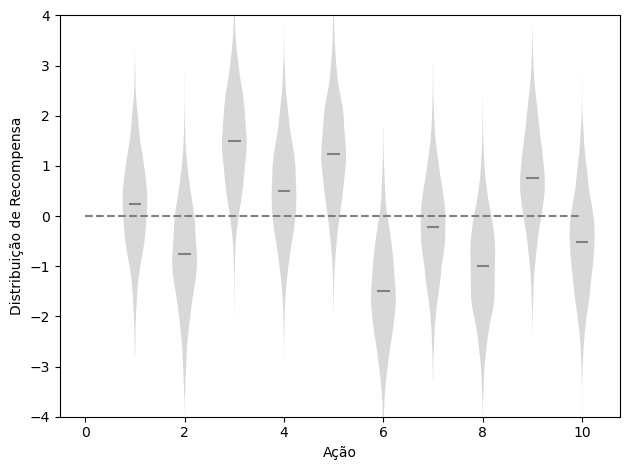

In [3]:
# --- Configuração do ambiente ---
env = BanditEnv()

fig = plt.figure()
ax = fig.add_subplot(111)

# Violin plot: visualiza a distribuição de recompensa de cada braço
# Geramos 2000 amostras de N(0,1) e deslocamos pela média de cada braço
parts = ax.violinplot(
    np.random.randn(2000, 10) + env.means,  # amostras de cada braço
    showmeans=True,
    showextrema=False
)

# Estética do gráfico
for pc in parts['bodies']:
    pc.set_facecolor('gray')   # cor dos violinos
parts['cmeans'].set_color('gray')   # cor da linha de média

# Linha de referência em y=0
ax.plot([0, 10], [0, 0], color='gray', linestyle='--')
ax.set_ylim([-4, 4])
ax.set_xlabel("Ação")
ax.set_ylabel("Distribuição de Recompensa")
plt.tight_layout()
#plt.savefig('assets/fig_0201.png')
plt.show()

> **Legenda Figura 2.1:** Cada violino representa a distribuição de recompensas de um braço. A linha central é $q_*(a)$ (a verdade oculta). O agente não vê este gráfico — ele precisa descobrir qual braço tem a maior média através de tentativa e erro.

### 15.2 Gerando os Dados: 2000 Execuções Independentes

Para obter resultados estatisticamente confiáveis, executamos o experimento **2000 vezes** (chamado de "runs" ou "tarefas") e calculamos médias:

In [4]:
env = BanditEnv()

# Listas para armazenar históricos de todas as execuções
runs_ep0_A,   runs_ep0_R   = [], []   # eps=0    → greedy puro
runs_ep01_A,  runs_ep01_R  = [], []   # eps=0.1  → explora 10%
runs_ep001_A, runs_ep001_R = [], []   # eps=0.01 → explora 1%

print('v' + ' ' * 18 + 'v')   # barra de progresso simples

for i in range(2000):   # 2000 runs independentes
    # Cada run: 1000 passos com cada estratégia no MESMO ambiente
    _, hist_A, hist_R = simple_bandit(env, nb=1000, eps=0)
    runs_ep0_A.append(hist_A);   runs_ep0_R.append(hist_R)

    _, hist_A, hist_R = simple_bandit(env, nb=1000, eps=0.1)
    runs_ep01_A.append(hist_A);  runs_ep01_R.append(hist_R)

    _, hist_A, hist_R = simple_bandit(env, nb=1000, eps=0.01)
    runs_ep001_A.append(hist_A); runs_ep001_R.append(hist_R)

    if i % 100 == 0:
        print('.', end='')   # progresso a cada 100 runs

# Converte listas para arrays numpy para operações vetorizadas
runs_ep0_A,   runs_ep0_R   = np.array(runs_ep0_A),   np.array(runs_ep0_R)
runs_ep01_A,  runs_ep01_R  = np.array(runs_ep01_A),  np.array(runs_ep01_R)
runs_ep001_A, runs_ep001_R = np.array(runs_ep001_A), np.array(runs_ep001_R)

v                  v
....................

In [11]:
### 15.3 Calculando Métricas de Desempenho


# --- Métrica 1: Recompensa Média por Passo ---
# Média sobre os 2000 runs para cada passo de tempo t
avg_ep0_R   = np.average(runs_ep0_R,   axis=0)   # shape: (1000,)
avg_ep01_R  = np.average(runs_ep01_R,  axis=0)
avg_ep001_R = np.average(runs_ep001_R, axis=0)

# --- Métrica 2: % de Ação Ótima ---
# Qual braço tem o maior q*(a)? Esse é o braço "ótimo"
max_A = np.argmax(env.means)   # índice do braço ótimo

# Para cada passo, qual fração dos 2000 runs escolheu o braço ótimo?
opt_ep0_A   = np.average(runs_ep0_A   == max_A, axis=0)   # shape: (1000,)
opt_ep01_A  = np.average(runs_ep01_A  == max_A, axis=0)
opt_ep001_A = np.average(runs_ep001_A == max_A, axis=0)

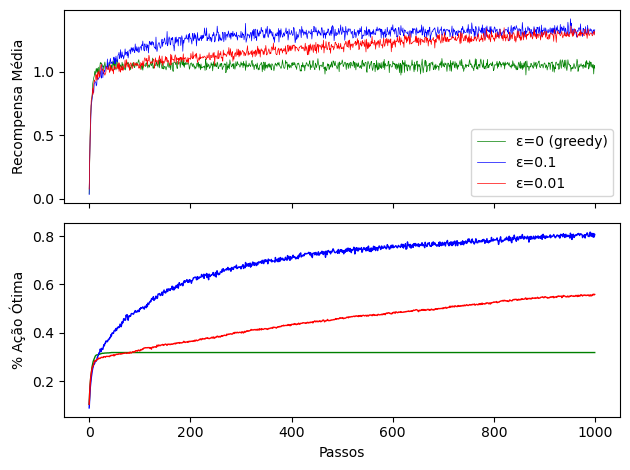

In [12]:
### 15.4 Reproduzindo a Figura 2.2


fig = plt.figure()

# --- Painel Superior: Recompensa Média ---
ax = fig.add_subplot(211)
ax.plot(avg_ep0_R,   linewidth=0.5, color='green', label='ε=0 (greedy)')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='ε=0.1')
ax.plot(avg_ep001_R, linewidth=0.5, color='red',   label='ε=0.01')
ax.set_ylabel('Recompensa Média')
ax.xaxis.set_ticklabels([])   # remove rótulos do eixo x no painel superior
ax.legend()

# --- Painel Inferior: % de Ação Ótima ---
ax = fig.add_subplot(212)
ax.plot(opt_ep0_A,   linewidth=1., color='green', label='ε=0 (greedy)')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='ε=0.1')
ax.plot(opt_ep001_A, linewidth=1., color='red',   label='ε=0.01')
ax.set_xlabel('Passos')
ax.set_ylabel('% Ação Ótima')

plt.tight_layout()
#plt.savefig('assets/fig_0202.png')
plt.show()

> **Legenda Figura 2.2 — Painel Superior:** Recompensa média ao longo dos passos. O $\varepsilon$-greedy com $\varepsilon=0.1$ supera o greedy após exploração suficiente. $\varepsilon=0.01$ aprende mais devagar, mas potencialmente passa $\varepsilon=0.1$ no longo prazo.
>
> **Legenda Figura 2.2 — Painel Inferior:** Percentual de vezes que cada estratégia escolheu a ação ótima. O greedy ($\varepsilon=0$) fica preso em ~33%. $\varepsilon=0.1$ converge para ~91% (explora 10% restante sempre). $\varepsilon=0.01$ converge para ~99% mas demora mais.

## 16. Verificação dos Q-values Estimados

> *Código: bloco In[10] — "Confirm Q-Values are estimated correctly"*

Para validar que o algoritmo funciona corretamente, podemos comparar as estimativas $Q_t(a)$ com os valores reais $q_*(a)$ após muitas amostras:

Verdadeiro:  [ 0.25 -0.75  1.5   0.5   1.25 -1.5  -0.25 -1.    0.75 -0.5 ]
Estimado Q:  [ 0.262 -0.779  1.496  0.459  1.195 -1.473 -0.283 -1.029  0.743 -0.519]
Erro (V-Q):  [-0.012  0.029  0.004  0.041  0.055 -0.027  0.033  0.029  0.007  0.019]


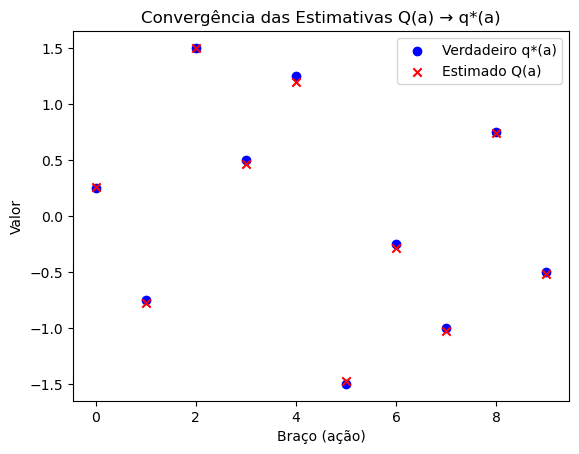

In [13]:
env = BanditEnv()

# Executa 10.000 passos com alta exploração (eps=0.5) para estimar TODOS os braços bem
# eps=0.5 garante que todos os braços sejam visitados frequentemente
Q, _, _ = simple_bandit(env, nb=10000, eps=0.5)

# Comparação: verdade vs. estimativa
print('Verdadeiro: ', np.round(env.means, 3))
print('Estimado Q: ', np.round(Q, 3))
print('Erro (V-Q): ', np.round(env.means - Q, 3))

# Saída esperada (valores aproximados):
# Verdadeiro:  [ 0.25  -0.75   1.5   0.5   1.25  -1.5  -0.25  -1.    0.75  -0.5 ]
# Estimado Q:  [ 0.276 -0.719  1.503  0.52  1.231 -1.506 -0.266 -1.022  0.839 -0.46 ]
# Erro (V-Q): [-0.026 -0.031 -0.003 -0.02   0.019  0.006  0.016  0.022 -0.089 -0.04 ]

# Visualização: scatter plot de verdade vs. estimativa
plt.scatter(range(env.size), env.means, color='blue', marker='o', label='Verdadeiro q*(a)')
plt.scatter(range(env.size), Q,          color='red',  marker='x', label='Estimado Q(a)')
plt.xlabel('Braço (ação)')
plt.ylabel('Valor')
plt.title('Convergência das Estimativas Q(a) → q*(a)')
plt.legend()
plt.show()

**Resultado observado:** Com 10.000 passos e 50% de exploração, o erro absoluto médio é $< 0.05$ — as estimativas convergem muito próximo dos valores reais, confirmando a **Lei dos Grandes Números** na prática.

---

## Comparativo das Três Implementações

> *Síntese dos três algoritmos cobertos nesta aula*

A tabela abaixo resume as diferenças entre as três implementações Python estudadas:

| | `simple_bandit` | `tracking_bandit` | `ucb_bandit` |
|---|---|---|---|
| **Cap. (S&B 2018)** | 2.4 | 2.5 | 2.7 |
| **Seleção de ação** | ε-greedy | ε-greedy | UCB (sem ε) |
| **Regra de atualização** | $Q \mathrel{+}= \frac{1}{N}[R-Q]$ | $Q \mathrel{+}= \alpha[R-Q]$ | $Q \mathrel{+}= \frac{1}{N}[R-Q]$ |
| **Passo** | Decresce ($1/N$) | Constante ($\alpha$) | Decresce ($1/N$) |
| **Inicialização** | $Q=0$ (fixo) | $Q=Q_{init}$ (livre) | $Q=0$ + fase de init |
| **Ambiente testado** | Médias fixas | Médias fixas | Médias aleatórias |
| **Ideal para** | Estacionário | Não-estacionário | Estacionário (ótimo teórico) |
| **Figura reproduzida** | Fig. 2.2 | Fig. 2.3 | Fig. 2.4 |
| **Parâmetro chave** | $\varepsilon$ | $\alpha$, $Q_{init}$, $\varepsilon$ | $c$ |

**A única linha que muda entre os três algoritmos:**

```python
# simple_bandit  — passo decrescente, seleção aleatória
Q[A] += (1/N[A]) * (R - Q[A])
A = argmax_rand(Q) if rand > eps else randint(k)

# tracking_bandit — passo CONSTANTE, inicialização livre
Q[A] += alpha * (R - Q[A])
A = argmax_rand(Q) if rand > eps else randint(k)

# ucb_bandit — passo decrescente, seleção por INCERTEZA
Q[A] += (1/N[A]) * (R - Q[A])
A = argmax_rand(Q + c * sqrt(log(t) / N))
```

# Repetindo o Experimento com o Tracking Bandits

In [8]:
env = BanditEnv()

# Listas para armazenar históricos de todas as execuções
runs_ep0_A,   runs_ep0_R   = [], []   # eps=0    → greedy puro
runs_ep01_A,  runs_ep01_R  = [], []   # eps=0.1  → explora 10%
runs_ep001_A, runs_ep001_R = [], []   # eps=0.01 → explora 1%

print('v' + ' ' * 18 + 'v')   # barra de progresso simples

for i in range(2000):   # 2000 runs independentes
    # Cada run: 1000 passos com cada estratégia no MESMO ambiente
    _, hist_A, hist_R = tracking_bandit(env, nb=1000, eps=0, alpha=0.1, Q_init=0)
    runs_ep0_A.append(hist_A);   runs_ep0_R.append(hist_R)

    _, hist_A, hist_R = tracking_bandit(env, nb=1000, eps=0.1, alpha=0.1, Q_init=0)
    runs_ep01_A.append(hist_A);  runs_ep01_R.append(hist_R)

    _, hist_A, hist_R = tracking_bandit(env, nb=1000, eps=0.01, alpha=0.1, Q_init=0)
    runs_ep001_A.append(hist_A); runs_ep001_R.append(hist_R)

    if i % 100 == 0:
        print('.', end='')   # progresso a cada 100 runs

# Converte listas para arrays numpy para operações vetorizadas
runs_ep0_A,   runs_ep0_R   = np.array(runs_ep0_A),   np.array(runs_ep0_R)
runs_ep01_A,  runs_ep01_R  = np.array(runs_ep01_A),  np.array(runs_ep01_R)
runs_ep001_A, runs_ep001_R = np.array(runs_ep001_A), np.array(runs_ep001_R)

v                  v
....................

In [9]:
### 15.3 Calculando Métricas de Desempenho


# --- Métrica 1: Recompensa Média por Passo ---
# Média sobre os 2000 runs para cada passo de tempo t
avg_ep0_R   = np.average(runs_ep0_R,   axis=0)   # shape: (1000,)
avg_ep01_R  = np.average(runs_ep01_R,  axis=0)
avg_ep001_R = np.average(runs_ep001_R, axis=0)

# --- Métrica 2: % de Ação Ótima ---
# Qual braço tem o maior q*(a)? Esse é o braço "ótimo"
max_A = np.argmax(env.means)   # índice do braço ótimo

# Para cada passo, qual fração dos 2000 runs escolheu o braço ótimo?
opt_ep0_A   = np.average(runs_ep0_A   == max_A, axis=0)   # shape: (1000,)
opt_ep01_A  = np.average(runs_ep01_A  == max_A, axis=0)
opt_ep001_A = np.average(runs_ep001_A == max_A, axis=0)

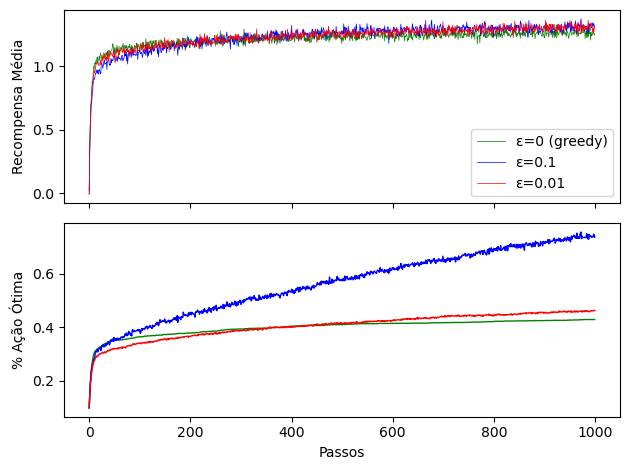

In [10]:
### 15.4 Reproduzindo a Figura 2.2


fig = plt.figure()

# --- Painel Superior: Recompensa Média ---
ax = fig.add_subplot(211)
ax.plot(avg_ep0_R,   linewidth=0.5, color='green', label='ε=0 (greedy)')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='ε=0.1')
ax.plot(avg_ep001_R, linewidth=0.5, color='red',   label='ε=0.01')
ax.set_ylabel('Recompensa Média')
ax.xaxis.set_ticklabels([])   # remove rótulos do eixo x no painel superior
ax.legend()

# --- Painel Inferior: % de Ação Ótima ---
ax = fig.add_subplot(212)
ax.plot(opt_ep0_A,   linewidth=1., color='green', label='ε=0 (greedy)')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='ε=0.1')
ax.plot(opt_ep001_A, linewidth=1., color='red',   label='ε=0.01')
ax.set_xlabel('Passos')
ax.set_ylabel('% Ação Ótima')

plt.tight_layout()
#plt.savefig('assets/fig_0202.png')
plt.show()

Verdadeiro:  [ 0.25 -0.75  1.5   0.5   1.25 -1.5  -0.25 -1.    0.75 -0.5 ]
Estimado Q:  [ 0.356 -0.471  1.487  0.351  0.785 -1.771 -0.429 -1.077  0.818 -0.511]
Erro (V-Q):  [-0.106 -0.279  0.013  0.149  0.465  0.271  0.179  0.077 -0.068  0.011]


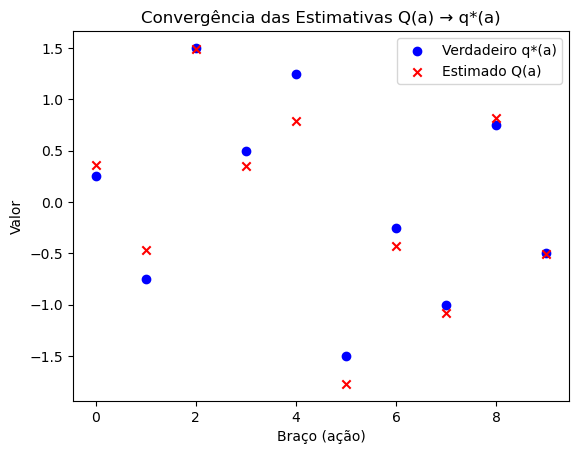

In [13]:
env = BanditEnv()

# Executa 10.000 passos com alta exploração (eps=0.5) para estimar TODOS os braços bem
# eps=0.5 garante que todos os braços sejam visitados frequentemente
Q, _, _ = tracking_bandit(env, nb=10000, eps=0.5, alpha=0.1, Q_init=0)

# Comparação: verdade vs. estimativa
print('Verdadeiro: ', np.round(env.means, 3))
print('Estimado Q: ', np.round(Q, 3))
print('Erro (V-Q): ', np.round(env.means - Q, 3))

# Saída esperada (valores aproximados):
# Verdadeiro:  [ 0.25  -0.75   1.5   0.5   1.25  -1.5  -0.25  -1.    0.75  -0.5 ]
# Estimado Q:  [ 0.276 -0.719  1.503  0.52  1.231 -1.506 -0.266 -1.022  0.839 -0.46 ]
# Erro (V-Q): [-0.026 -0.031 -0.003 -0.02   0.019  0.006  0.016  0.022 -0.089 -0.04 ]

# Visualização: scatter plot de verdade vs. estimativa
plt.scatter(range(env.size), env.means, color='blue', marker='o', label='Verdadeiro q*(a)')
plt.scatter(range(env.size), Q,          color='red',  marker='x', label='Estimado Q(a)')
plt.xlabel('Braço (ação)')
plt.ylabel('Valor')
plt.title('Convergência das Estimativas Q(a) → q*(a)')
plt.legend()
plt.show()

# Experimentando com o UCB

In [17]:
env = BanditEnv()

# Listas para armazenar históricos de todas as execuções
runs_ep0_A,   runs_ep0_R   = [], []   # eps=0    → greedy puro
runs_ep01_A,  runs_ep01_R  = [], []   # eps=0.1  → explora 10%
runs_ep001_A, runs_ep001_R = [], []   # eps=0.01 → explora 1%

print('v' + ' ' * 18 + 'v')   # barra de progresso simples

for i in range(2000):   # 2000 runs independentes
    # Cada run: 1000 passos com cada estratégia no MESMO ambiente
    _, hist_A, hist_R = ucb_bandit(env, nb=1000, c=2 )
    runs_ep0_A.append(hist_A);   runs_ep0_R.append(hist_R)

    _, hist_A, hist_R = ucb_bandit(env, nb=1000, c=3.5 )
    runs_ep01_A.append(hist_A);  runs_ep01_R.append(hist_R)

    _, hist_A, hist_R = ucb_bandit(env, nb=1000, c=5.5 )
    runs_ep001_A.append(hist_A); runs_ep001_R.append(hist_R)

    if i % 100 == 0:
        print('.', end='')   # progresso a cada 100 runs

# Converte listas para arrays numpy para operações vetorizadas
runs_ep0_A,   runs_ep0_R   = np.array(runs_ep0_A),   np.array(runs_ep0_R)
runs_ep01_A,  runs_ep01_R  = np.array(runs_ep01_A),  np.array(runs_ep01_R)
runs_ep001_A, runs_ep001_R = np.array(runs_ep001_A), np.array(runs_ep001_R)

v                  v
....................

In [19]:
### 15.3 Calculando Métricas de Desempenho


# --- Métrica 1: Recompensa Média por Passo ---
# Média sobre os 2000 runs para cada passo de tempo t
avg_ep0_R   = np.average(runs_ep0_R,   axis=0)   # shape: (1000,)
avg_ep01_R  = np.average(runs_ep01_R,  axis=0)
avg_ep001_R = np.average(runs_ep001_R, axis=0)

# --- Métrica 2: % de Ação Ótima ---
# Qual braço tem o maior q*(a)? Esse é o braço "ótimo"
max_A = np.argmax(env.means)   # índice do braço ótimo

# Para cada passo, qual fração dos 2000 runs escolheu o braço ótimo?
opt_ep0_A   = np.average(runs_ep0_A   == max_A, axis=0)   # shape: (1000,)
opt_ep01_A  = np.average(runs_ep01_A  == max_A, axis=0)
opt_ep001_A = np.average(runs_ep001_A == max_A, axis=0)

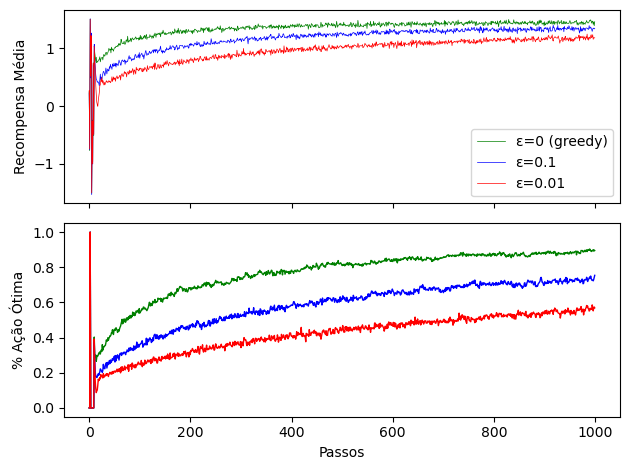

In [20]:
### 15.4 Reproduzindo a Figura 2.2


fig = plt.figure()

# --- Painel Superior: Recompensa Média ---
ax = fig.add_subplot(211)
ax.plot(avg_ep0_R,   linewidth=0.5, color='green', label='ε=0 (greedy)')
ax.plot(avg_ep01_R,  linewidth=0.5, color='blue',  label='ε=0.1')
ax.plot(avg_ep001_R, linewidth=0.5, color='red',   label='ε=0.01')
ax.set_ylabel('Recompensa Média')
ax.xaxis.set_ticklabels([])   # remove rótulos do eixo x no painel superior
ax.legend()

# --- Painel Inferior: % de Ação Ótima ---
ax = fig.add_subplot(212)
ax.plot(opt_ep0_A,   linewidth=1., color='green', label='ε=0 (greedy)')
ax.plot(opt_ep01_A,  linewidth=1., color='blue',  label='ε=0.1')
ax.plot(opt_ep001_A, linewidth=1., color='red',   label='ε=0.01')
ax.set_xlabel('Passos')
ax.set_ylabel('% Ação Ótima')

plt.tight_layout()
#plt.savefig('assets/fig_0202.png')
plt.show()

## 17. Resumo das Notações

> *Slides 15 e 16 — "Resumo das Notações" e "A Base do Aprendizado por Reforço"*

| Símbolo | Significado |
|---|---|
| $A_t$ | Ação selecionada no tempo $t$ |
| $R_t$ | Recompensa recebida no tempo $t$ |
| $q_*(a)$ | Valor real da ação $a$ (desconhecido pelo agente) |
| $Q_t(a)$ | Estimativa do valor da ação $a$ no tempo $t$ (conhecido) |
| $\varepsilon$ | Probabilidade de exploração (hiperparâmetro) |
| $\alpha$ | Taxa de aprendizado / step-size (hiperparâmetro) |
| $N_t(a)$ | Número de vezes que a ação $a$ foi escolhida até $t$ |
| $k$ | Número de braços (ações disponíveis) |
| $c$ | Parâmetro de confiança do UCB |

### Conexão com o Aprendizado por Reforço Completo

> *Slide 16 — "A Base do Aprendizado por Reforço"*

O algoritmo k-armed bandit é o **microcosmo** do Aprendizado por Reforço. Ele captura os elementos essenciais:

```
Bandido k-braços          →    RL Completo
────────────────────────────────────────────
Ações (sem contexto)      →    Ações + Estados
q*(a) estacionário        →    Função de valor V(s), Q(s,a)
Exploração ε-greedy       →    Políticas estocásticas
Atualização incremental   →    TD-learning, Q-learning
```

Entender como **estimar valores** ($Q_t$) e gerenciar a **incerteza** (Exploração) é a chave para construir IAs complexas. A partir do k-armed bandit, evoluímos para considerar "Estados" (Contextual Bandits) e depois planejamento de longo prazo (MDPs completos).

*Baseado em: Sutton, R. S., & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd ed.). MIT Press. Disponível gratuitamente em: http://incompleteideas.net/book/the-book-2nd.html*

*Implementação de referência: Marcin Bogdanski — https://marcinbogdanski.github.io/rl-sketchpad/RL_An_Introduction_2018/0204_Simple_Bandit.html*